## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Arthropoda - Steven</h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)



# 1. Introduction <a class="anchor" id="intro"></a>

In this second notebook, we will preprocess images from the **Arthropoda** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [18]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
import itertools
import random

# Libraries for image processing
from glob import glob
from PIL import Image
import cv2


In [19]:
#Libraries from Keras / TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import gc
from tensorflow.keras import backend as K


#import tensorflow_hub as hub

#Import pre-trained models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess




In [20]:
tf.config.run_functions_eagerly(False)


# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Arthropoda Phylum.

In [21]:
# Load the DataFrame from the CSV file
arthropoda_train = pd.read_csv("/home/sacar/DeepLearning2425/train_test_splits/arthropoda_train.csv")
arthropoda_train.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,28260809,1065329,animalia,arthropoda,apidae,arthropoda_apidae/28260809_1065329_eol-full-si...
1,29945328,1077217,animalia,arthropoda,pseudophasmatidae,arthropoda_pseudophasmatidae/29945328_1077217_...
2,14644212,463474,animalia,arthropoda,formicidae,arthropoda_formicidae/14644212_463474_eol-full...


In [22]:
# Load the DataFrame from the CSV file
arthropoda_test = pd.read_csv("/home/sacar/DeepLearning2425/train_test_splits/arthropoda_test.csv")
arthropoda_test.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,28408206,1065346,animalia,arthropoda,apidae,arthropoda_apidae/28408206_1065346_eol-full-si...
1,28253620,1065348,animalia,arthropoda,apidae,arthropoda_apidae/28253620_1065348_eol-full-si...
2,21847584,1065348,animalia,arthropoda,apidae,arthropoda_apidae/21847584_1065348_eol-full-si...


# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

In [ ]:
#Funciton to process with clahe
def process_image_with_clahe(image_path, size=(224, 224)):
    """
    Loads an image, resizes it, and applies CLAHE.
    Returns the resized image and the CLAHE-enhanced version.
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load: {image_path}")
            return None, None

        # Convert to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize
        resized_img = cv2.resize(img_rgb, size, interpolation=cv2.INTER_AREA)

        # Convert to LAB and apply CLAHE
        lab = cv2.cvtColor(resized_img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

        return resized_img, img_clahe

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None


In [24]:
# Map model names to their preprocessors and classes
model_map = {
    'resnet50':      (ResNet50,      resnet_preprocess),
    'MobileNetV2':   (MobileNetV2,   mobilenet_preprocess),
    'efficientnetb0':(EfficientNetB0, efficientnet_preprocess),
    'densenet121':   (DenseNet121,   densenet_preprocess),
    'inceptionv3':   (InceptionV3,   inception_preprocess),
}


In [25]:
#Function for preprocessing
def process_image(file_path, label, preprocess_fn):
    def _load_with_clahe(path):
        # Convert bytes to string
        path = path.numpy().decode('utf-8')
        _, img_clahe = process_image_with_clahe(path)
        return img_clahe.astype(np.uint8)

    # Call OpenCV CLAHE function using tf.py_function
    image = tf.py_function(_load_with_clahe, [file_path], Tout=tf.uint8)

    # Set the shape manually, TensorFlow can't infer it after tf.py_function
    image.set_shape([224, 224, 3])

    # Cast and apply model-specific preprocessing
    image = tf.cast(image, tf.float32)

    if preprocess_fn:
        image = preprocess_fn(image)
    else:
        image = image / 255.0

    return image, label

#Function to augment the images
def augment_image(image, label):

    #Randomly change brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    #Apply geometric augmentations
    image = geometric_augmentation_layers(image, training=True) # Apply geometric augmentations
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


# Geometric augmentations
geometric_augmentation_layers = tf.keras.Sequential(
    [
        # Randomly flip horizontally
        tf.keras.layers.RandomFlip("horizontal"),

        # Randomly rotate
        tf.keras.layers.RandomRotation(factor=0.12),

        # Random zoom
        tf.keras.layers.RandomZoom(height_factor=(-0.35, 0.35), # Corresponds to [0.8, 1.2] of original height
                                   width_factor=(-0.35, 0.35)), # Corresponds to [0.8, 1.2] of original width

        # Random shift
        tf.keras.layers.RandomTranslation(height_factor=0.20,
                                          width_factor=0.20),

        # Contrast
        tf.keras.layers.RandomContrast(factor=0.25),

    ],
    name="geometric_augmentations",
)


In [26]:
#Define some stuff
num_classes = arthropoda_train['family'].nunique() #number of classes = number of families
batch_size = 64
input_shape = (224, 224, 3)
image_size = (224, 224)
value_range = (0.0, 1.0)
num_classes = 17  

# Define callbacks
my_callbacks = [
callbacks.EarlyStopping(patience=10, restore_best_weights=True),
callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]



# Import data

In [27]:
'''
# Load pickle
with open(pkl_path, 'rb') as f:
    chordata_train_clean = pickle.load(f)

# Get images and labels
train_images = chordata_train_clean['resized_image'].tolist()
train_labels = chordata_train_clean['family'].tolist()

# Encode labels
label_names = sorted(set(train_labels))
label_to_index = {name: i for i, name in enumerate(label_names)}
train_labels = np.array([label_to_index[label] for label in train_labels], dtype=np.int32)

# Build train dataset
train_dataset = build_dataset(train_images, train_labels, preprocess_fn=None, augment=True)
'''

"\n# Load pickle\nwith open(pkl_path, 'rb') as f:\n    chordata_train_clean = pickle.load(f)\n\n# Get images and labels\ntrain_images = chordata_train_clean['resized_image'].tolist()\ntrain_labels = chordata_train_clean['family'].tolist()\n\n# Encode labels\nlabel_names = sorted(set(train_labels))\nlabel_to_index = {name: i for i, name in enumerate(label_names)}\ntrain_labels = np.array([label_to_index[label] for label in train_labels], dtype=np.int32)\n\n# Build train dataset\ntrain_dataset = build_dataset(train_images, train_labels, preprocess_fn=None, augment=True)\n"

In [28]:
# Define root directory
root_dir = "/home/sacar/DeepLearning2425/rare_species"

# Construct full image paths
arthropoda_train['full_path'] = arthropoda_train['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))
arthropoda_test['full_path'] = arthropoda_test['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))

# Extract file paths and labels
file_paths_train = arthropoda_train['full_path'].tolist()
labels_train = arthropoda_train['family'].tolist()

file_paths_test = arthropoda_test['full_path'].tolist()
labels_test = arthropoda_test['family'].tolist()

# Map string labels to integer indices
label_names = sorted(set(labels_train))
label_to_index = {name: i for i, name in enumerate(label_names)}

# Encode labels
labels_train = [label_to_index[label] for label in labels_train]
labels_test = [label_to_index[label] for label in labels_test]

# Convert to numpy arrays
labels_train = np.array(labels_train, dtype=np.int32)
labels_test = np.array(labels_test, dtype=np.int32)

# --- Train/Validation Split ---
combined = list(zip(file_paths_train, labels_train))
random.seed(42)
random.shuffle(combined)

file_paths_train, labels_train = zip(*combined)  # Still tuples at this point
split_index = int(0.8 * len(file_paths_train))

train_paths = list(file_paths_train[:split_index])
train_labels = np.array(labels_train[:split_index], dtype=np.int32)
val_paths   = list(file_paths_train[split_index:])
val_labels  = np.array(labels_train[split_index:], dtype=np.int32)
file_paths_test = list(file_paths_test)  # Ensure it's a list
labels_test = np.array(labels_test, dtype=np.int32)

print("Train size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Test size:", len(file_paths_test))

Train size: 589
Validation size: 148
Test size: 185


# Function to build dataset

In [29]:
def build_dataset(inputs, labels, preprocess_fn=None, augment=False):
    import tensorflow as tf

    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))

    # Determine whether inputs are paths (strings) or already arrays
    if isinstance(inputs[0], str):
        # Case 1: inputs are file paths → need to read images from disk
        dataset = dataset.map(lambda x, y: process_image(x, y, preprocess_fn), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        # Case 2: inputs are arrays → they are already images
        if preprocess_fn:
            dataset = dataset.map(lambda x, y: (preprocess_fn(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.cache()
    
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True, seed=42)

    dataset = dataset.batch(8).prefetch(tf.data.AUTOTUNE)

    return dataset



# Confirm GPU is working

In [30]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
# Print GPU devices detected
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU(s) detected: {[gpu.name for gpu in gpus]}")
else:
    print("No GPU detected by TensorFlow.")

✅ GPU(s) detected: ['/physical_device:GPU:0']


# Run Models and Plot Results

In [ ]:
def run_random_search(train, val, num_classes, base_model_class, n_trials=10, seed=42):
    import random, itertools, gc
    from tensorflow.keras import layers, models, backend as K
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    import pandas as pd
    import tensorflow.keras as keras

    random.seed(seed)
    '''
    This is the total search space. To run a particular instance, set the values in the repeated code below.
    # Hyperparameter search space
    dropout_rates = [0.5, 0.6]
    dense_units_list = [64, 128]
    learning_rates = [5e-5, 1e-4, .0002]
    patience_values = [5, 7]
    freeze_until_layers = [120, 140, 160]
    optimizers_list = ['adam']
    '''
    # Hyperparameter search space
    dropout_rates = [0.5]
    dense_units_list = [128]
    learning_rates = [.0002]
    patience_values = [7]
    freeze_until_layers = [160]
    optimizers_list = ['adam']

    # Generate all possible combinations
    all_combinations = list(itertools.product(
        dropout_rates,
        dense_units_list,
        learning_rates,
        patience_values,
        freeze_until_layers,
        optimizers_list
    ))

    sampled_combinations = random.sample(all_combinations, k=min(n_trials, len(all_combinations)))
    results = []

    # Load weights only once
    base_model_template = base_model_class(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_weights = base_model_template.get_weights()
    del base_model_template

    for i, (dropout, units, lr, patience, freeze_until, opt_name) in enumerate(sampled_combinations):
        print(f"\n Trial {i+1}/{len(sampled_combinations)}")
        print(f"Dropout={dropout}, Units={units}, LR={lr}, Patience={patience}, FreezeUntil={freeze_until}")

        base_model = base_model_class(
            input_shape=(224, 224, 3),
            include_top=False,
            weights=None  # important!
        )
        base_model.set_weights(base_weights)
        base_model.trainable = False

        def create_optimizer():
            return keras.optimizers.Adam(learning_rate=lr)

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(dropout),
            layers.Dense(units, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=create_optimizer(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        callbacks_list = [
            EarlyStopping(patience=patience, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=max(1, patience // 2)),
            #ModelCheckpoint(f"{base_model_class.__name__}_V2_clahe{i+1}.keras", save_best_only=True)
            ModelCheckpoint(f"Final_Arthropoda_MobileNet_Clahe{i+1}.keras", save_best_only=True)
        ]

        # Phase 1 training
        history1 = model.fit(
            train,
            validation_data=val,
            epochs=50,
            callbacks=callbacks_list,
            verbose=1
        )

        # Phase 2 fine-tuning
        base_model.trainable = True
        for layer in base_model.layers[:freeze_until]:
            layer.trainable = False

        model.compile(
            optimizer=create_optimizer(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        history2 = model.fit(
            train,
            validation_data=val,
            epochs=50,
            callbacks=callbacks_list,
            verbose=1
        )

        final_val_acc = history2.history['val_accuracy'][-1]

        results.append({
            'dropout': dropout,
            'dense_units': units,
            'learning_rate': lr,
            'patience': patience,
            'freeze_until': freeze_until,
            'optimizer': opt_name,
            'val_accuracy': final_val_acc
        })

        # Cleanup
        del model, base_model, history1, history2, callbacks_list
        K.clear_session()
        gc.collect()

    # RETURN after the loop ends
    return pd.DataFrame(results)


In [33]:
def plot_random_search_results(results_df, top_n=5):
    sns.set(style="whitegrid")

    # -------------------------------
    # 1. Top N Configurations by Val Accuracy
    # -------------------------------
    top_configs = results_df.sort_values(by='val_accuracy', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_configs, x='val_accuracy', y=top_configs.index, hue='dropout')
    plt.title(f"Top {top_n} Hyperparameter Configs by Validation Accuracy")
    plt.xlabel("Validation Accuracy")
    plt.ylabel("Config Index")
    plt.legend(title="Dropout")
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # 2. Strip plots: Accuracy vs Each Hyperparam
    # -------------------------------
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Validation Accuracy vs Hyperparameters", fontsize=16)

    sns.stripplot(data=results_df, x='dropout', y='val_accuracy', ax=axs[0, 0])
    axs[0, 0].set_title("Dropout")

    sns.stripplot(data=results_df, x='dense_units', y='val_accuracy', ax=axs[0, 1])
    axs[0, 1].set_title("Dense Units")

    sns.stripplot(data=results_df, x='learning_rate', y='val_accuracy', ax=axs[0, 2])
    axs[0, 2].set_title("Learning Rate")

    sns.stripplot(data=results_df, x='patience', y='val_accuracy', ax=axs[1, 0])
    axs[1, 0].set_title("EarlyStopping Patience")

    sns.stripplot(data=results_df, x='freeze_until', y='val_accuracy', ax=axs[1, 1])
    axs[1, 1].set_title("Freeze Until Layer")

    axs[1, 2].axis('off')  # Empty slot

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # -------------------------------
    # 3. Heatmap (e.g. Dropout vs Units)
    # -------------------------------
    pivot_table = results_df.pivot_table(
        values='val_accuracy',
        index='dropout',
        columns='dense_units',
        aggfunc='mean'
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
    plt.title("Heatmap: Dropout vs Dense Units (Val Accuracy)")
    plt.xlabel("Dense Units")
    plt.ylabel("Dropout Rate")
    plt.tight_layout()
    plt.show()



>>> Running model: MobileNetV2


 Trial 1/1
Dropout=0.5, Units=128, LR=0.0002, Patience=7, FreezeUntil=160
Epoch 1/50


I0000 00:00:1745912306.969888    3525 service.cc:152] XLA service 0x7f6294004630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745912306.969967    3525 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-04-29 08:38:27.073723: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745912308.289067    3525 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0327 - loss: 3.5686     

I0000 00:00:1745912314.640839    3525 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 230ms/step - accuracy: 0.1869 - loss: 2.9059 - val_accuracy: 0.3581 - val_loss: 2.1267 - learning_rate: 2.0000e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3852 - loss: 2.1314 - val_accuracy: 0.3784 - val_loss: 1.9389 - learning_rate: 2.0000e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4463 - loss: 1.8867 - val_accuracy: 0.3986 - val_loss: 1.8217 - learning_rate: 2.0000e-04
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5213 - loss: 1.6913 - val_accuracy: 0.4797 - val_loss: 1.7031 - learning_rate: 2.0000e-04
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5130 - loss: 1.6703 - val_accuracy: 0.5405 - val_loss: 1.5763 - learning_rate: 2.0000e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5367 - loss: 1.5553 - val_accuracy: 0.5541 - val_loss: 1.4677 - learning_rate: 2.0000e-04
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5319 - loss: 1

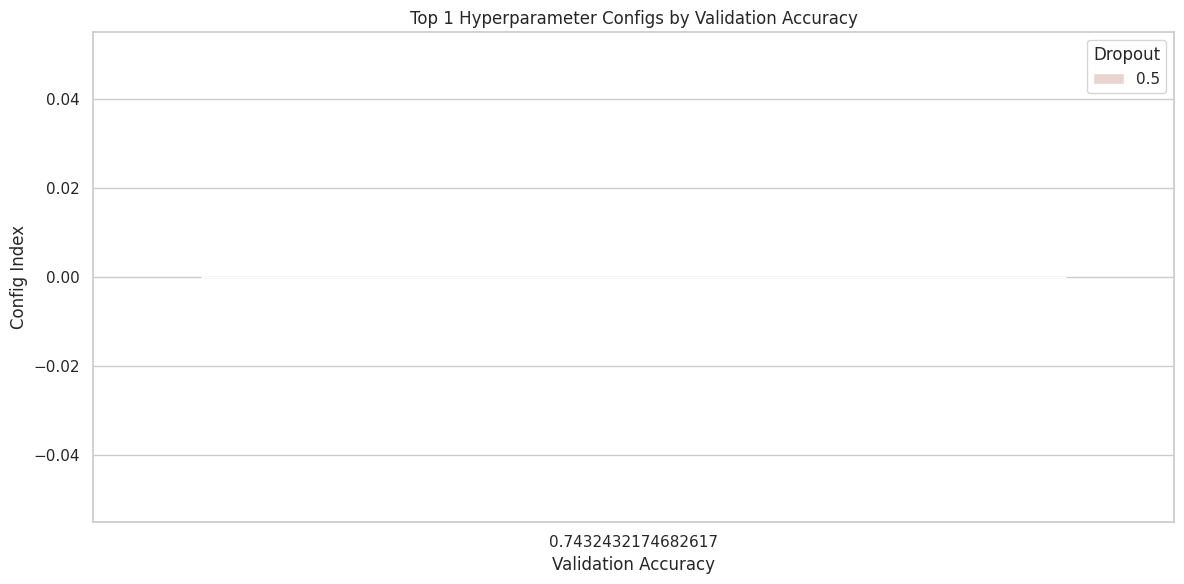

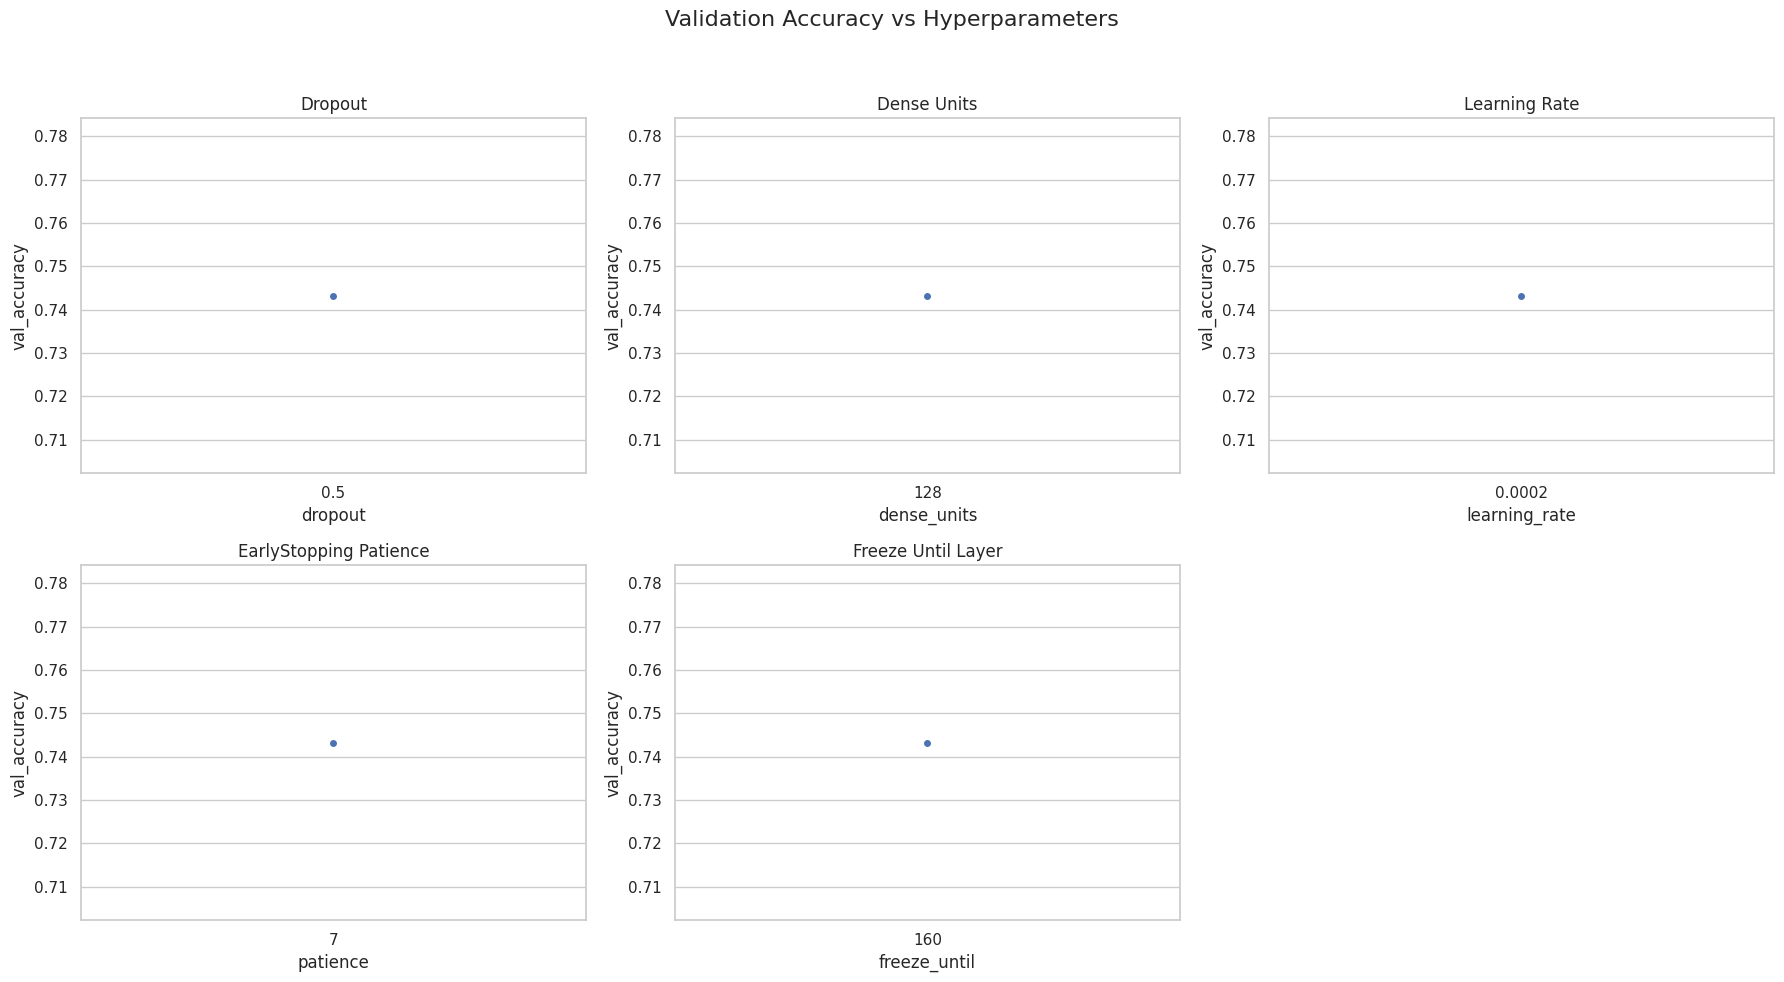

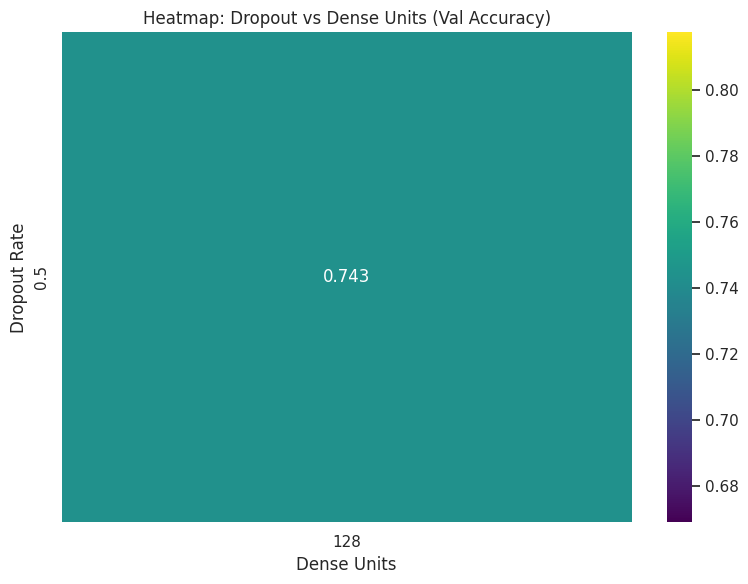

In [34]:
#Use models_list to define which models you want to run in one go. Choose from the list below.
#models_list = ['inceptionv3', 'MobileNetV2', 'efficientnetb0', 'densenet121', 'resnet50']
models_list = ['MobileNetV2']

for model_name in models_list:
    print(f"\n>>> Running model: {model_name}\n")

    # Get model constructor and preprocessing function from your model map
    base_model_class, preprocess_fn = model_map[model_name]

    # Build datasets using clean inputs
    train = build_dataset(train_paths, train_labels, preprocess_fn, augment=True)
    val   = build_dataset(val_paths, val_labels, preprocess_fn, augment=False)
    test  = build_dataset(file_paths_test, labels_test, preprocess_fn, augment=False)

    # Run hyperparameter search
    results = run_random_search(
        train, val, num_classes,
        base_model_class=base_model_class,
        n_trials=10,
        seed=42
    )

    # Plot results
    plot_random_search_results(results, top_n=1)




